In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
features = pd.read_csv('temps.csv')
features.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [5]:
#处理时间数据
import datetime

years = features['year']
months = features['month']
days = features['day']

#datetime格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

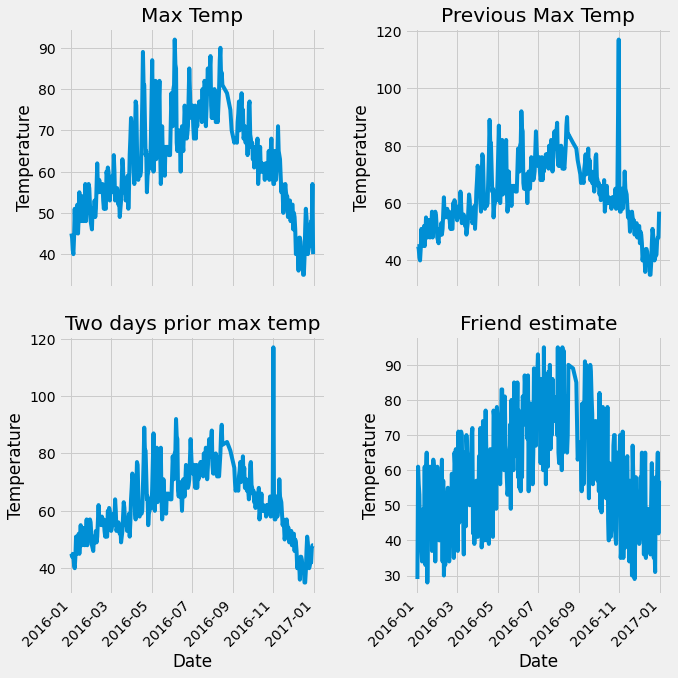

In [6]:
#指定图表默认风格
plt.style.use('fivethirtyeight')

#设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
fig.autofmt_xdate(rotation=45)

#设置标签值
ax1.plot(dates, features['actual'])
ax1.set_xlabel('')
ax1.set_ylabel('Temperature')
ax1.set_title('Max Temp')

#昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel('')
ax2.set_ylabel('Temperature')
ax2.set_title('Previous Max Temp')

#前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date')
ax3.set_ylabel('Temperature')
ax3.set_title('Two days prior max temp')

#friend
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date')
ax4.set_ylabel('Temperature')
ax4.set_title('Friend estimate')

plt.tight_layout(pad=2)

In [12]:
#转化为独热编码（因为week这一列为str类型，所以需要转换）
features = pd.get_dummies(features)
features.head()

,year,month,day,temp_2,temp_1,average,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,46,46,46,41,0,0,0,0,0,1,0


In [14]:
#定义标签
labels = np.array(features['actual'])
#在特征中去掉标签
features = features.drop('actual', axis=1)
#名字单独保存一下，以备后用
feature_list = list(features.columns)
#转换成合适的格式
features = np.array(features)

KeyError: 'actual'

In [15]:
features.shape

(348, 17)

In [17]:
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)
input_features[0:5]

array([[ 0.        , -1.5678393 , -1.65682171, -1.45311448, -1.46252836,
        -1.3470703 , -1.34446055, -1.17460726, -1.4755089 , -1.98891668,
         2.44131112, -0.40482045, -0.40961596, -0.40482045, -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        , -1.5678393 , -1.54267126, -1.53543319, -1.46252836,
        -1.33755752, -1.53330909, -1.17460726, -1.4755089 ,  0.06187741,
        -0.40961596, -0.40482045,  2.44131112, -0.40482045, -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        , -1.5678393 , -1.4285208 , -1.45311448, -1.54515171,
        -1.32804474, -1.34446055, -1.55432238, -1.1948692 , -0.25855917,
        -0.40961596, -0.40482045, -0.40961596,  2.47023092, -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        , -1.5678393 , -1.31437034, -1.53543319, -1.79302178,
        -1.31853195, -1.25003627, -1.36446482, -1.28841577, -0.45082111,
        -0.40961596,  2.47023092, -0.40961596, -0.40482045, -0.40482045,
        -0.41913682

构建神经网络模型

In [18]:
x = torch.tensor(input_features, dtype=float)
y = torch.tensor(labels, dtype=float)

#权重参数初始化
#隐藏层包含128个节点（128个特征），输入features:[348,17], weights1:[17,128]
weights1 = torch.randn((17, 128), dtype=float, requires_grad=True)
biases1 = torch.randn(128, dtype=float, requires_grad=True)

#第二层，因为是线性回归，输出为一个值scalar，weights2：[128,1]
weights2 = torch.randn((128, 1), dtype=float, requires_grad=True)
biases2 = torch.randn(1, dtype=float, requires_grad=True)

learning_rate = 0.001
losses = []

for i in range(1000):
    #计算隐藏层
    hidden = x.mm(weights1) + biases1
    #加入激活函数
    hidden = torch.relu(hidden)
    #预测结果
    predictions = hidden.mm(weights2) + biases2
    #计算损失
    loss = torch.mean((predictions - y) ** 2)
    losses.append(loss.data.numpy())
    
    if i % 100 == 0:
        print('loss', loss)
    
    #反向传播
    loss.backward()
    
    #更新参数，梯度下降
    weights1.data.add_(- learning_rate * weights1.grad.data)
    biases1.data.add_(- learning_rate * biases1.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    biases2.data.add_(- learning_rate * biases2.grad.data)
    
    #每次迭代完成都要清空
    weights1.grad.data.zero_()
    biases1.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()

loss tensor(5712.6689, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(153.1571, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(147.1710, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(144.7818, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(143.4614, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(142.6092, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(142.0142, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(141.5860, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(141.2588, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(140.9977, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [19]:
predictions

tensor([[63.8725],
        [62.9962],
        [62.0017],
        [61.4550],
        [63.6927],
        [62.0666],
        [59.9606],
        [61.6364],
        [63.9315],
        [62.5579],
        [64.7501],
        [65.4847],
        [63.4471],
        [61.1911],
        [65.1181],
        [64.3143],
        [62.9849],
        [64.3593],
        [61.1099],
        [65.2022],
        [62.3298],
        [62.6499],
        [61.6571],
        [61.9805],
        [63.2661],
        [62.1354],
        [63.6663],
        [63.4449],
        [60.7304],
        [64.8637],
        [62.6667],
        [62.3382],
        [61.5568],
        [64.7103],
        [63.2620],
        [58.8601],
        [61.5412],
        [60.3538],
        [61.2366],
        [64.8273],
        [63.5641],
        [62.1679],
        [62.0851],
        [59.7000],
        [61.3161],
        [62.2030],
        [62.1880],
        [62.6133],
        [62.0799],
        [62.3114],
        [61.8118],
        [60.1159],
        [61.

In [20]:
input_features.shape

(348, 17)

2. 更简单的构建神经网络模型的方法

In [21]:
input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16
my_nn = torch.nn.Sequential(
    # Linear构建全连接层
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, output_size)
)
cost = torch.nn.MSELoss(reduce='mean')
optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)

In [23]:
#训练网络
losses = []
for i in range(1000):
    batch_loss = []
    # mini-batch方法来进行训练
    for start in range(0, len(input_features), batch_size):
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end], dtype=torch.float, requires_grad=True)
        yy = torch.tensor(labels[start:end], dtype=torch.float, requires_grad=True)
        prediction = my_nn(xx)
        loss = cost(prediction, yy)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        #更新参数
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))
            

0 35.392494
100 35.262444
200 35.158848
300 35.06631
400 34.9817
500 34.90921
600 34.83198
700 34.76837
800 34.7063
900 34.64626


预测训练结果

In [ ]:
# 为了简便，直接用训练集测试
test = torch.tensor(input_features, dtype=torch.float)
predict = my_nn(test).data.numpy()